In [50]:
# Imports
from lib.utils import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn.functional import relu,one_hot
from tqdm import tqdm
device = 'cuda'
torch.cuda.empty_cache()

In [51]:
X,y = load_raw_list([20,21,22,23,24])

In [52]:
p_idx = np.where(y==0)[0]
w_idx = np.where(y==2)[0]
idx = np.concatenate([p_idx,w_idx])
X = X[idx]
y = y[idx]
y[np.where(y==2)[0]] = 1

In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,stratify=y,random_state=0)
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=0)
# X_train, y_train = sm.fit_resample(X_train, y_train)
# X_train = torch.from_numpy(X_train)
# y_train = torch.from_numpy(y_train).reshape(-1,1).long()

In [54]:
y_train_one_hot = one_hot(y_train,num_classes=2).reshape(-1,2).float()
y_test_one_hot = one_hot(y_test,num_classes=2).reshape(-1,2).float()
X_train = X_train.reshape(-1,1,5000)
y_train_one_hot = y_train_one_hot
X_test = X_test.reshape(-1,1,5000)
y_test_one_hot = y_test_one_hot
from torch.utils.data import TensorDataset
training_data = TensorDataset(X_train,y_train_one_hot)
testing_data = TensorDataset(X_test,y_test_one_hot)
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=1024, shuffle=True)

In [55]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(1, 16, kernel_size=100, stride=10, padding=1)
        self.fc2 = nn.Linear(3920, 2)

    def forward(self,x):
        x = self.c1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = x.view(-1, 3920)
        x = self.fc2(x)
        
        return x
model = MLP().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [56]:
model(X_train[0].reshape(-1,1,5000).cuda()).shape

torch.Size([1, 2])

In [57]:
train_losses= []
test_losses = []

In [58]:
for epoch in range(1500):
    training_loss = 0
    model.train()
    for (X,y) in train_dataloader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    train_losses.append(training_loss/len(train_dataloader))
    model.eval()
    testing_loss = 0
    for (X,y) in test_dataloader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        testing_loss += loss.item()
    test_losses.append(testing_loss/len(test_dataloader))
    # if(epoch%10 == 0):
    print(f'Epoch {epoch} Train: {training_loss/len(train_dataloader)} Test: {testing_loss/len(test_dataloader)}')


Epoch 0 Train: 0.4137919299742755 Test: 0.34608458280563353
Epoch 1 Train: 0.34780937783858357 Test: 0.3497240602970123
Epoch 2 Train: 0.3380434232599595 Test: 0.33374686241149903
Epoch 3 Train: 0.3371296437347637 Test: 0.32774956822395324
Epoch 4 Train: 0.33697692786946015 Test: 0.34683648943901063
Epoch 5 Train: 0.336960668072981 Test: 0.3410490870475769
Epoch 6 Train: 0.33726534422706156 Test: 0.33379424214363096
Epoch 7 Train: 0.3366769306799945 Test: 0.32933069467544557
Epoch 8 Train: 0.336846930139205 Test: 0.33516311049461367
Epoch 9 Train: 0.3367734183283413 Test: 0.3351539194583893
Epoch 10 Train: 0.3369162135264453 Test: 0.3366176724433899
Epoch 11 Train: 0.3368423563592574 Test: 0.3234322965145111
Epoch 12 Train: 0.3366009294986725 Test: 0.3439298629760742
Epoch 13 Train: 0.33664818371043487 Test: 0.3321890354156494
Epoch 14 Train: 0.3368668363374822 Test: 0.33660606741905214
Epoch 15 Train: 0.33694936247432933 Test: 0.33971297144889834
Epoch 16 Train: 0.3368549469639273 Tes

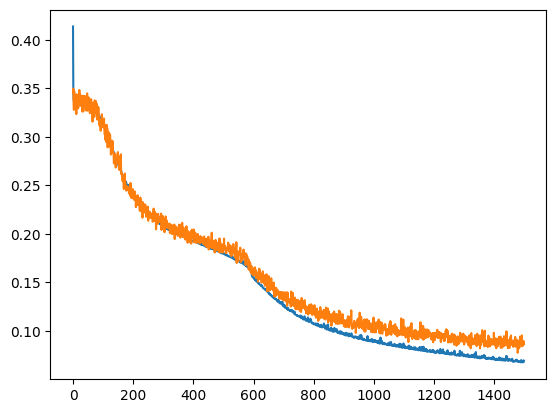

In [59]:
plt.plot(train_losses)
plt.plot(test_losses)

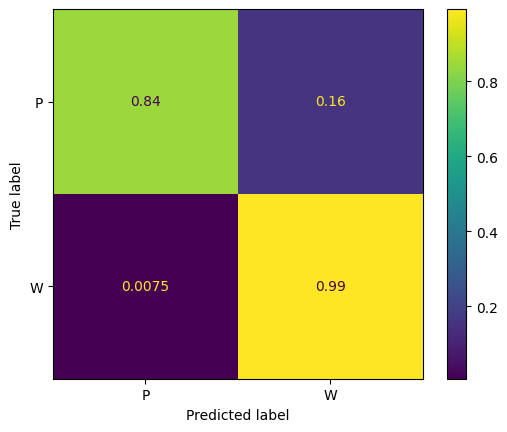

In [60]:
y_pred_logits = model(X_train.cuda())
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1)
cm = ConfusionMatrixDisplay(confusion_matrix(y_train_one_hot.argmax(axis=1).cpu().squeeze().cpu(),y_pred.cpu(),normalize='true'),display_labels=['P','W'])
cm.plot()

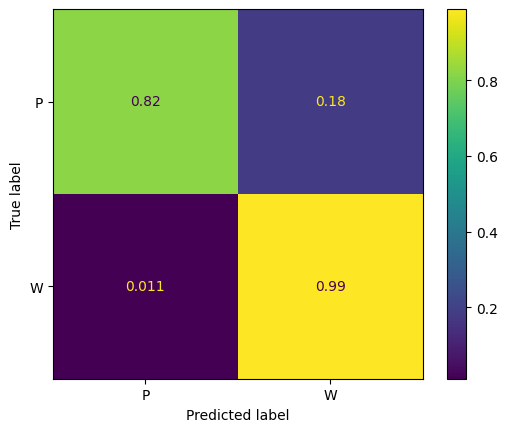

In [61]:
y_pred_logits = model(X_test.cuda())
sm = nn.Softmax(dim=1)
y_pred = sm(y_pred_logits).argmax(axis=1)
cm = ConfusionMatrixDisplay(confusion_matrix(y_test.squeeze(),y_pred.cpu(),normalize='true'),display_labels=['P','W'])
cm.plot()

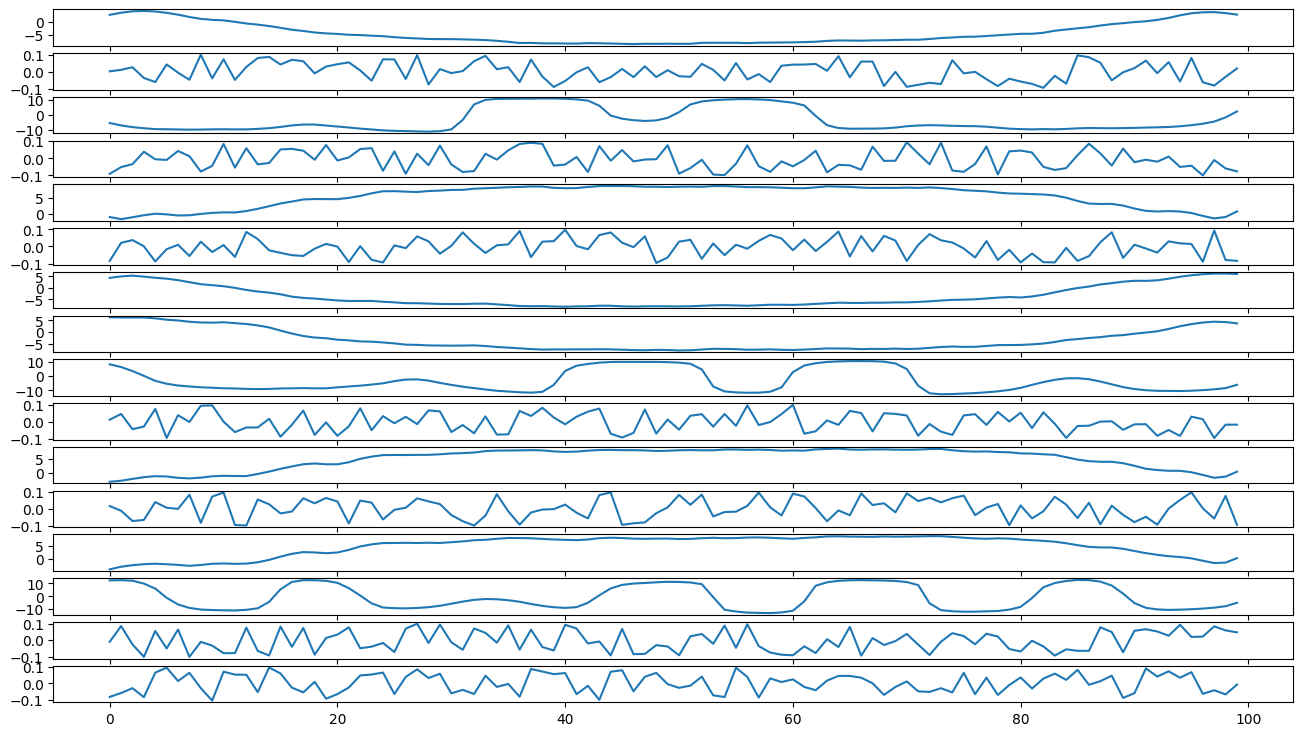

In [33]:
fig,axes = plt.subplots(nrows=len(model.c1.weight),ncols=1,figsize=(16,9))
for i in range(len(model.c1.weight)):
    axes[i].plot(model.c1.weight[i].squeeze().detach().cpu())
plt.savefig('kernels.jpg',dpi=200)